**Image segmentation** is a versatile, interesting area to explore and try out different machine learning techniques focusing on **computer vision algorithms**. Image segmentation creates a pixel-wise mask for each object in the image. Based on this concept, there are many algorithms that we can apply for image segmentation but to name a few that are highly efficient are - **k-means clustering, Mask R- CNN and U-Net**. We may also use Python **Open-CV** techniques to manipulate and mask image. However specifically for biomedical or microscopic image that requires multi semantic image segmention , U-Net would be a great algorithm to apply and achieve our desired custom segmentaion.

For U-Net we need to annotate our image for training purposes. Also **U-Net** **works very well when there are a large number of images for training and testing**.

For the sake of this assignment to mask a single image automatically I tried to explore Meta's recent published model - **SAM - Segment anything model**.

Though for some limitaion this time the model worked moderately to auto-generate the masks but I believe with some other modifications this would provide more accurate result. I will continue exploring the gaps and will try to fine tune the masking task. But for now I would like to present my works and explorations for this assignment.

I would highly appreciate if you kindly consider my efforts.

#Segment-Anything Model

Google colab has been used for this assignment

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setting up environment

In [4]:
using_colab = True

In [5]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu121
Torchvision version: 0.16.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-5gox76x4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-5gox76x4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=1cb6b823807688e017450c613d85e8eddd5ebe6949b421099a9d6dca9b036ab9
  Stored in directory: /tmp/pip-ephem-wheel-cache-8r4v1x6o/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-01-22 01:57:25--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.11, 3.

##Automatically generating mask technique for SAM model

In this section we will be using SamAutomaticMaskGenerator class that works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks.

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [14]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [15]:
image = cv2.imread('/content/drive/MyDrive/OPS_Assignment/cartidge.png') #reading the image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converting the image to RGB format

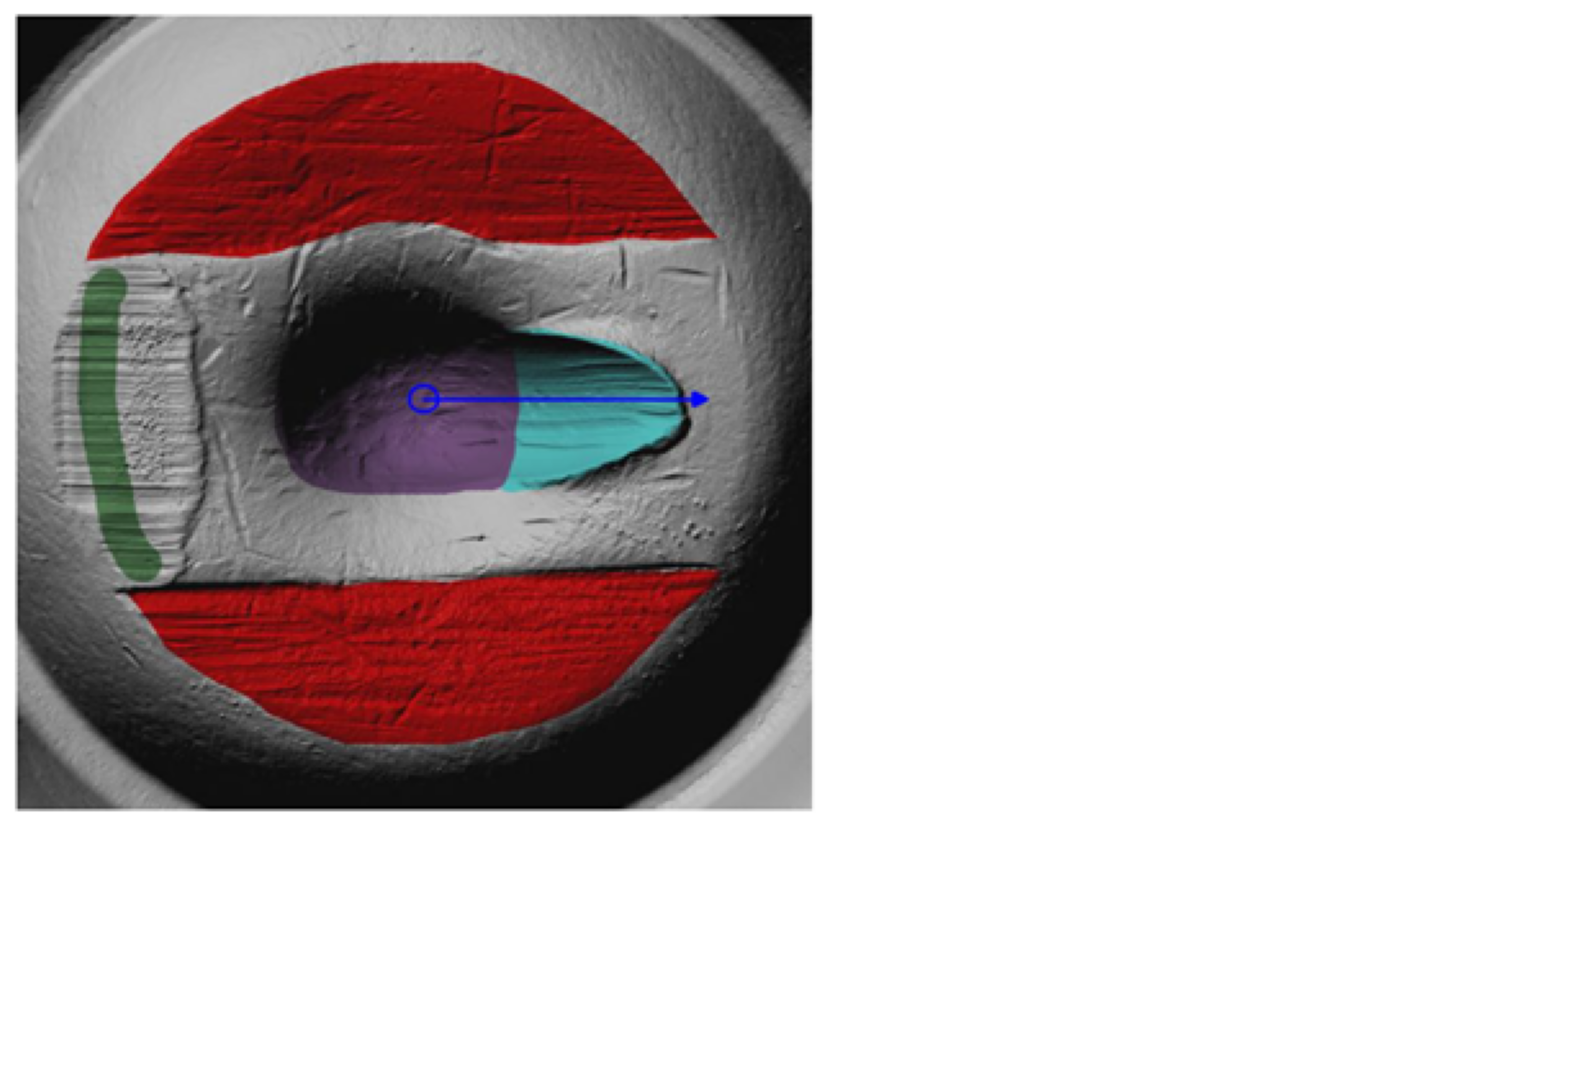

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

Below we are setting up the pathto the SAM checkpoint. Running on CUDA and with the default model.

In [17]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [18]:
masks = mask_generator.generate(image)

In [19]:
print(len(masks))
print(masks[0].keys())

20
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


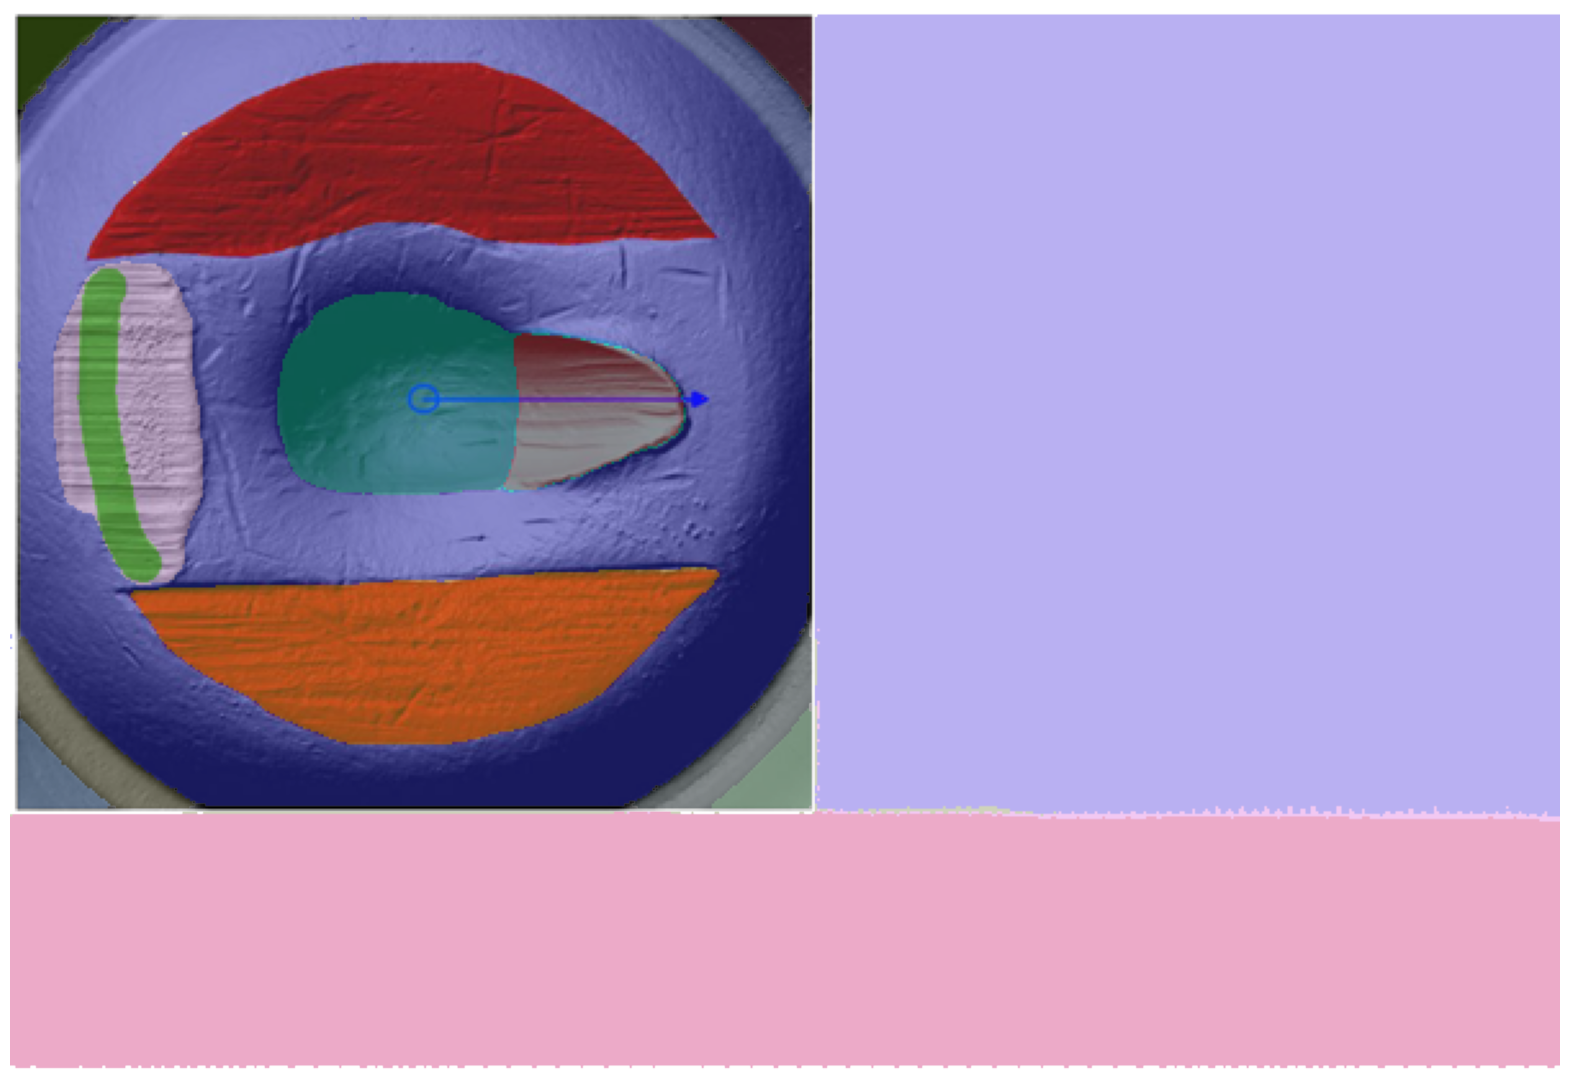

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

For the above we notice that the autogenerating function did not work well to seperate the area of masking using the default algorithm. Below we will try to modify the parameters and generate different versions of mask based on different thresholds.

In [21]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [22]:
masks2 = mask_generator_2.generate(image)

In [23]:
len(masks2)

22

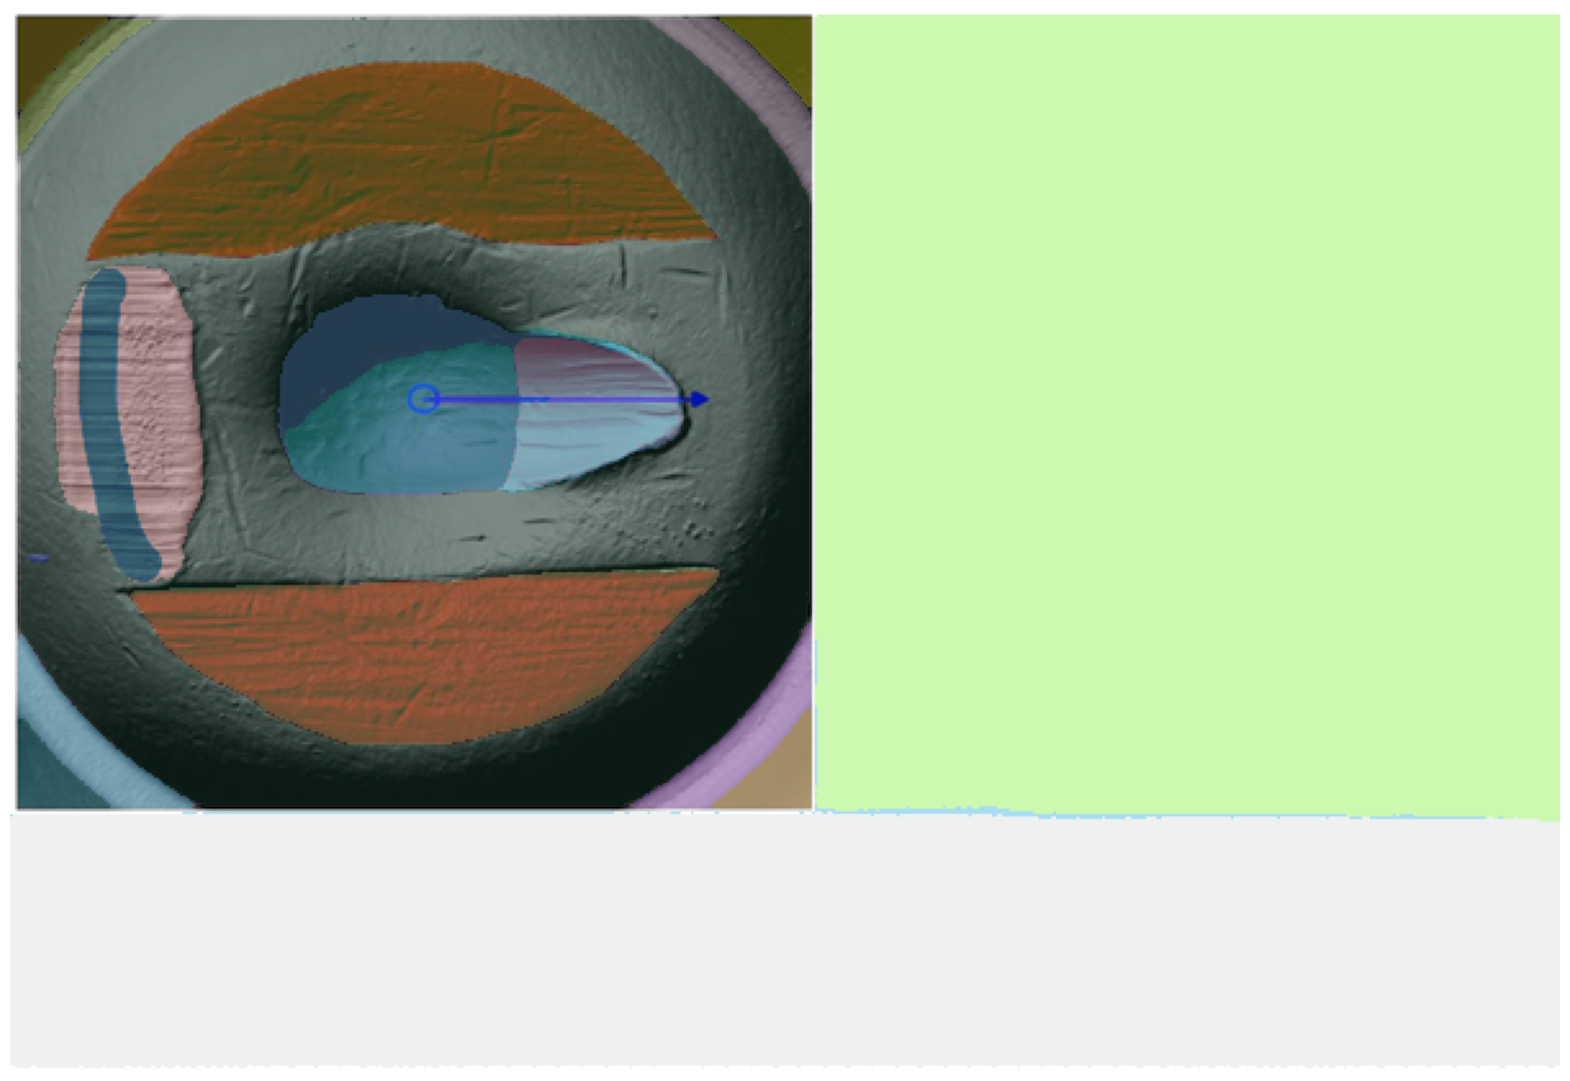

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

##Predictor technique for SAM model

In this section, we will try the SamPredictor class that provides an easy interface to the model for prompting the model. It calculates the necessary image embeddings first and then prompts can be provided via the predict method to predict masks from those prompts.

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [8]:
image = cv2.imread('/content/drive/MyDrive/OPS_Assignment/cartidge.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

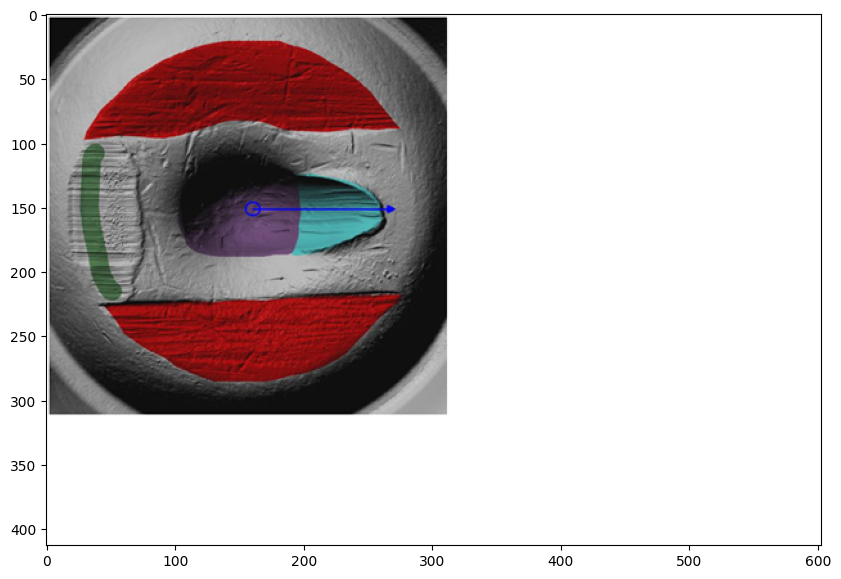

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [78]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [79]:
predictor.set_image(image)

### Specifying a single point

In [36]:
input_point = np.array([[150, 50]]) #Specifying a point for masking that is represented by the green star
input_label = np.array([1])

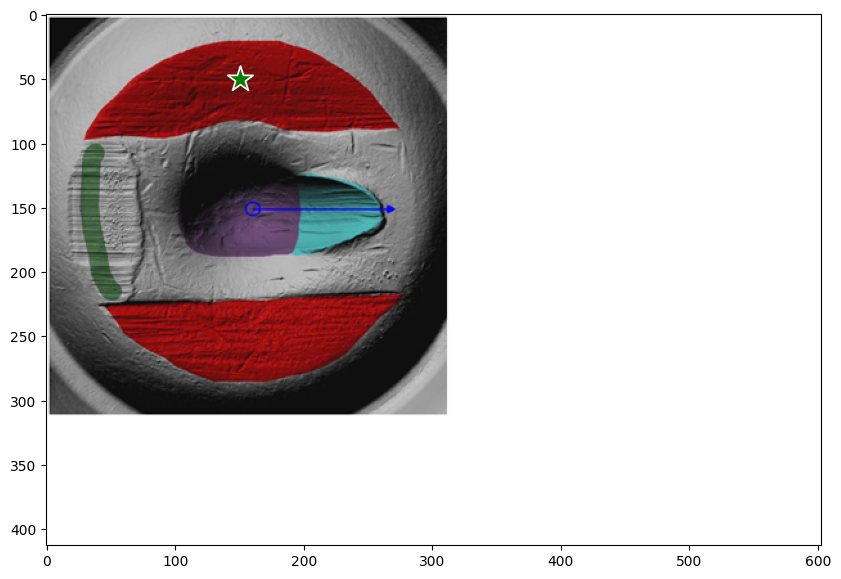

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [81]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [39]:
masks.shape  # (number_of_masks) x H x W

(3, 413, 603)

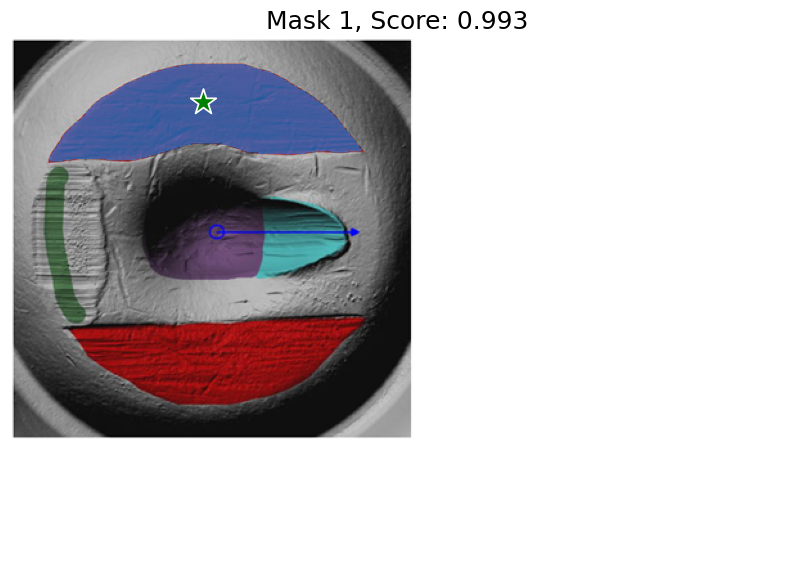

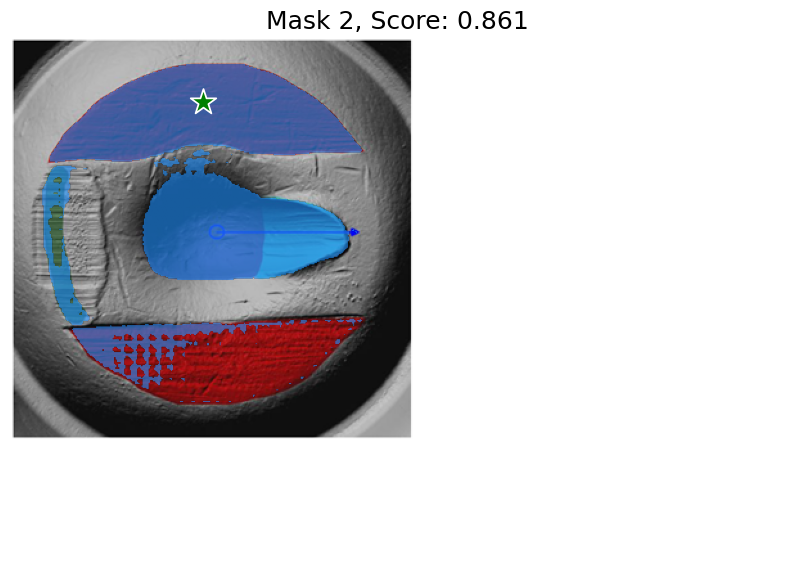

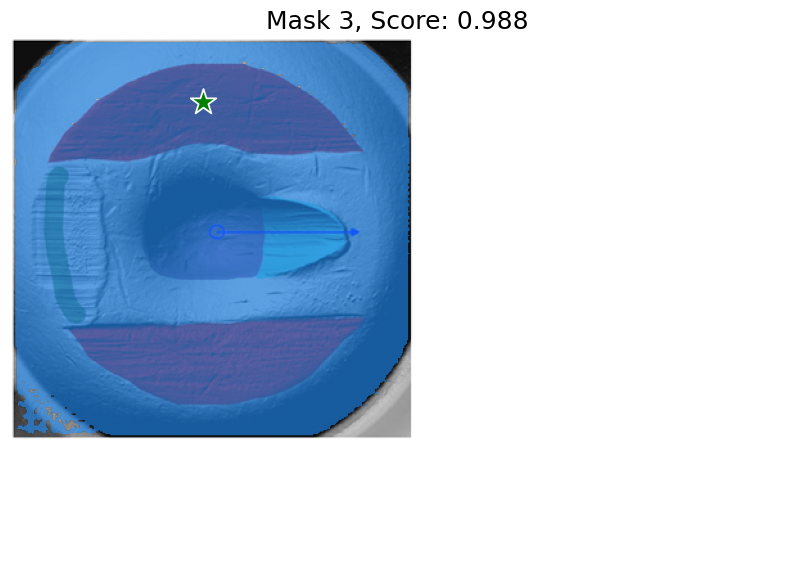

In [40]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


###Specifying multiple points


In [42]:
input_point = np.array([[100, 50], [150, 150]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [43]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [44]:
masks.shape

(1, 413, 603)

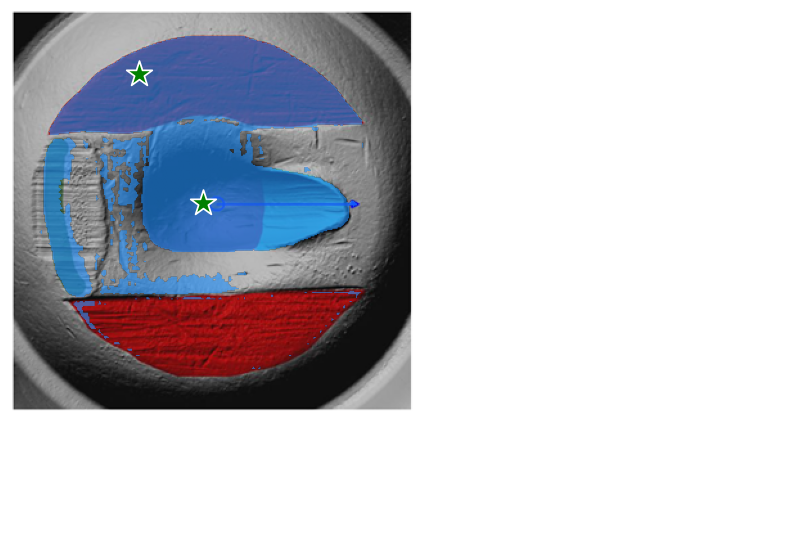

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [46]:
input_point = np.array([[100, 50], [150, 150]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [47]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

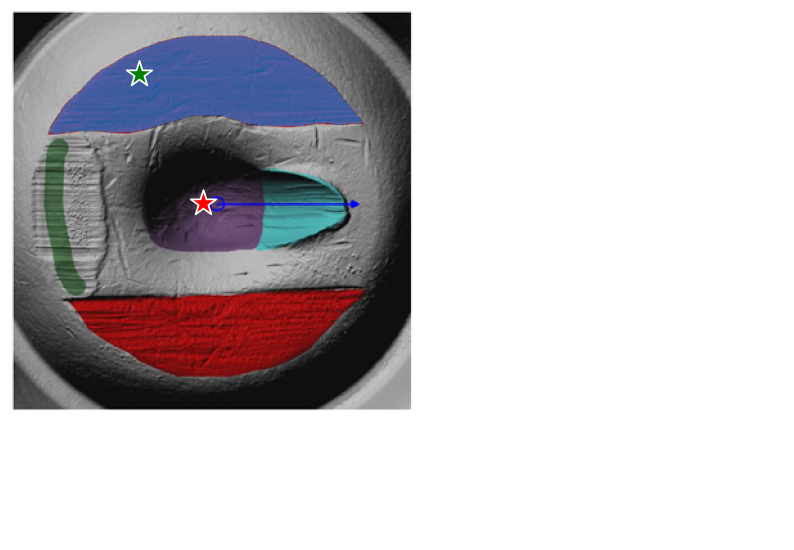

In [48]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [83]:
input_point = np.array([[100, 50], [250, 150]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [84]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [85]:
masks.shape

(1, 413, 603)

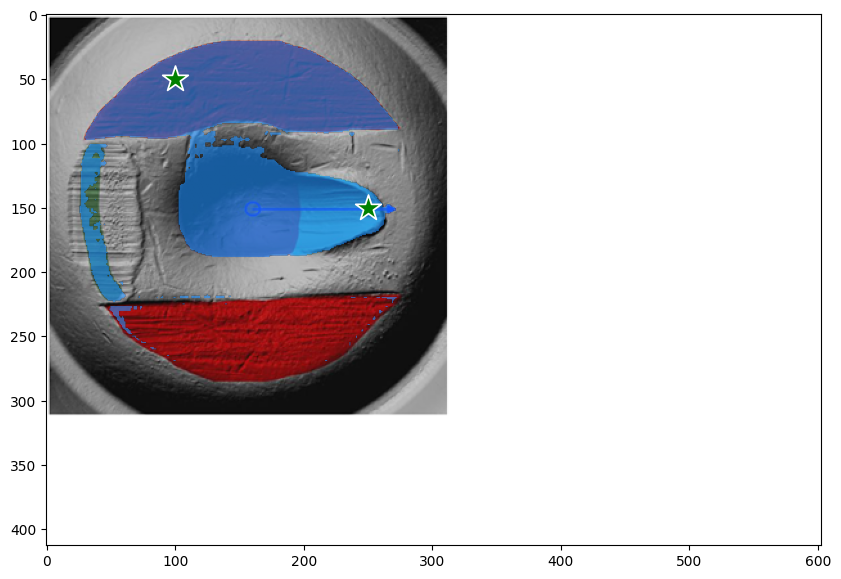

In [86]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [87]:
input_point = np.array([[100, 50], [250, 150]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [88]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [89]:
masks.shape

(1, 413, 603)

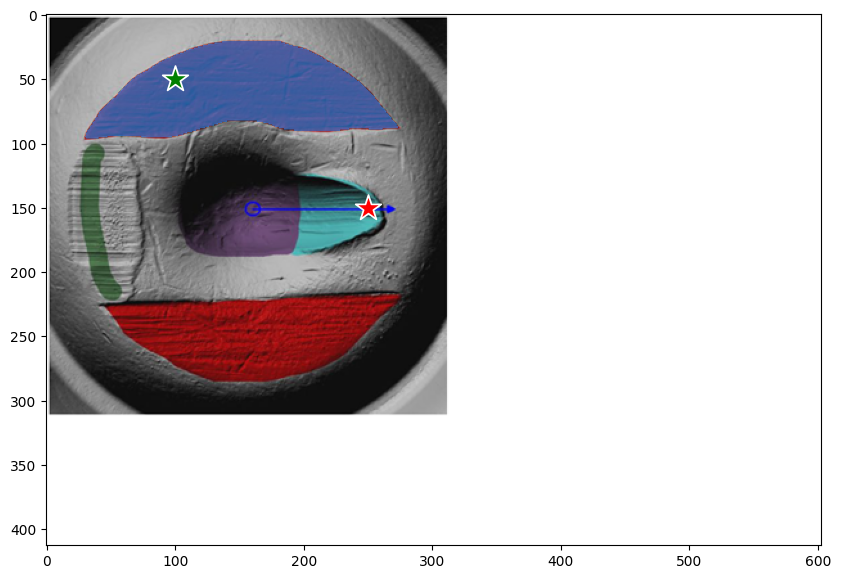

In [90]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In the above section we tried multiple points method where it specifies region front and back for masking. We tried different points location to see how the masking results work.

###Specifying object with a box


In this section we try to specify our targeted area with a box in the xyxy format.

In [33]:
input_box = np.array([190, 185, 265, 125]) #specifying the area with the box

In [34]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

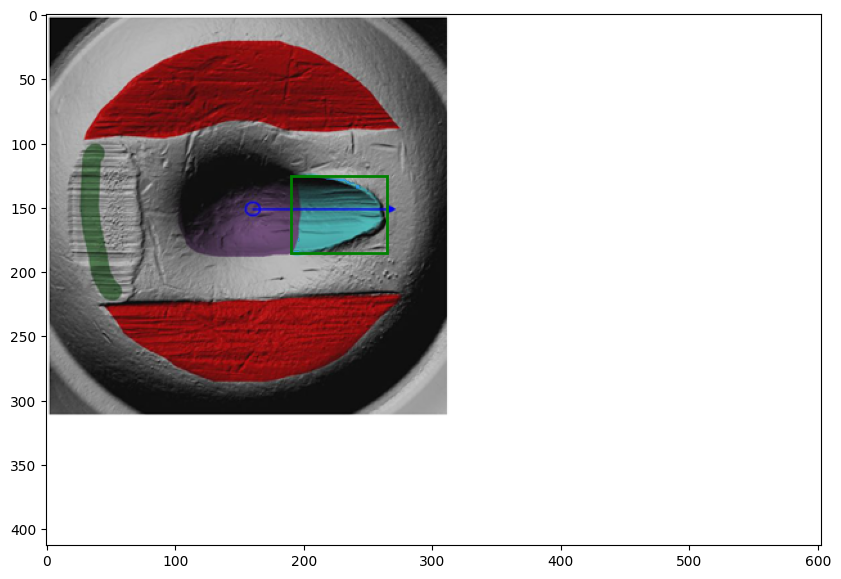

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

In [51]:
#Combining points and boxes as inputs to specify the exact region
input_box = np.array([190, 185, 265, 125])
input_point = np.array([[220, 150]])
input_label = np.array([0])

In [52]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

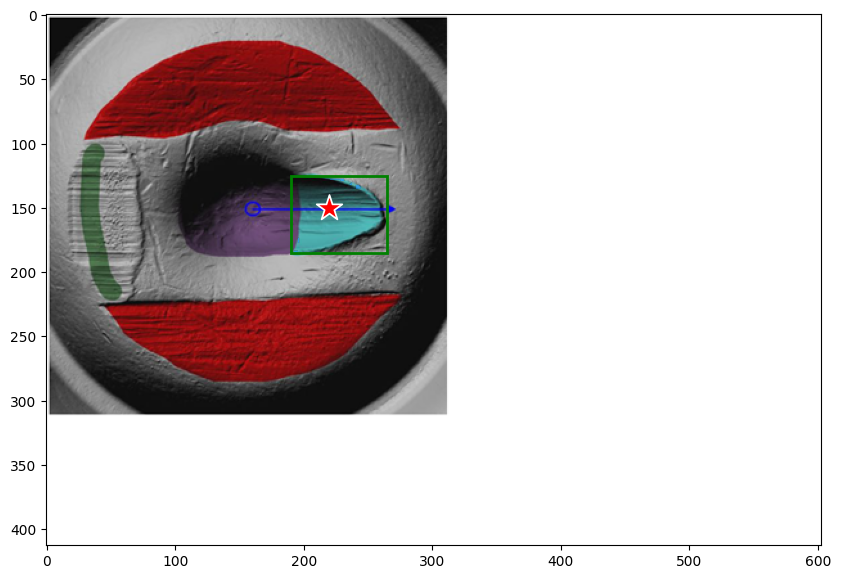

In [54]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

### Batched Prompt specifying multiple boxes as different targeted areas

Here we will be using predict_torch technique. SamPredictor can take multiple input prompts for the same image, using predict_torch method. This method assumes input points are already torch tensors and have already been transformed to the input frame. It transforms the boxes to the input frame, then predict masks. SamPredictor stores the necessary transform as the transform field for easy access.

In [73]:
input_boxes = torch.tensor([
    [40, 100, 270, 25],
    [30, 225, 50, 100],
    [100, 180, 200, 100],
    [100, 150, 200, 140],
    [190, 185, 265, 125]
], device=predictor.device)

In [74]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [75]:
masks.shape

torch.Size([5, 1, 413, 603])

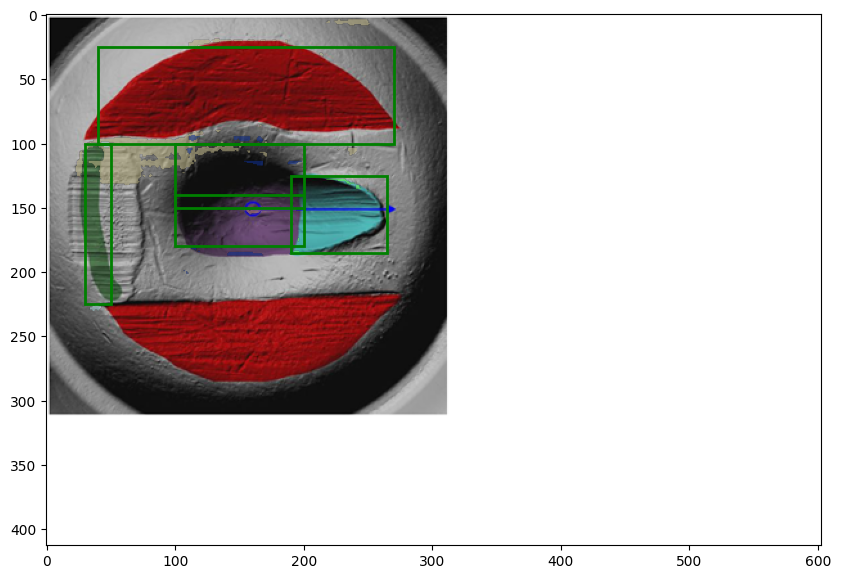

In [76]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color= True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('on')
plt.show()

We successfully provide our targeted boxing area. But the mask generation is not clearly visualized. I will continue finding out the gaps and will try to improve the training model by fine tuning paramenters. In conclusison, I would say this algorithm could be a great tool for automatically mask generation task.